# Quora Question Pairs

### Metrice(s):
- Log Loss.
- Binary Confusion Matrix.

## 2.3 Train and Test Construction

We build train and test by randomly splitting in the ration of <font color='red'><b>70:30</b></font> or <font color='red'><b>80:20</b></font> whatever we choose as we have sufficient points to work with.
**NOTE:** Time-based splittin would be efficient, but since we don't have the timestamp of the questions, we can't use it.

## 3. Exploratory Data Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from subprocess import check_output # New to the course
import plotly.offline as py # New to the Course
py.init_notebook_mode(connected=True) # New to the Course
import plotly.graph_objs as go # New to the Course
import plotly.tools as tls # New to the Course
import os
import gc # New to the course

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%precision 2
plt.style.use('ggplot')
sns.set_style('white')

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-question-pairs/sample_submission.csv
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/train.csv


## 3.1 Reading data and Basic Stats

In [4]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv')

print('Number of data points:', df.shape[0])

Number of data points: 404290


In [5]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
249826,249826,78130,363553,What are the benefits of meditation? How do yo...,What are the five benefits of meditation?,1
239831,239831,351509,351510,Hike with 8 years of experience?,How can I keep my mind free by distraction?,0
202710,202710,836,99465,Why can't I stop watching porn?,Why should one stop watching porn?,0
242544,242544,354768,354769,Why does Salman Khan act same in his every movie?,Why does Salman Khan dance like a monkey in hi...,0
347351,347351,409039,119910,How can I become A gigolo?,How can one become a gigolo?,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Observation:
- we can see from `info`, that `question1` and `question2` columns have some null values, but it's not that much.

We are given a minimal number of data fields here, consisting of:
- id: Looks like a simple rowID.
- qid{1, 2}: The unique ID of each question in the pair.
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicated of each other.

## 3.2.1 Distribution of data points among output classes
Number of duplicate(similar) and non-duplicate(non-similar) questions.

In [7]:
def show_annotation(colName):
    # Add Anootations
    n_points = df.shape[0]
    duplicate_count = df[colName].value_counts()
    locs, labels = plt.xticks() # Get the current tick locations and labels

    # Loop for through each pair of locations and labels.
    for loc, label in zip(locs, labels):
        count = duplicate_count[int(label.get_text())]
        text  = '{:.2f}%'.format(100*count/n_points)
        plt.text(loc, count-50, text, ha='center', color='darkblue')  

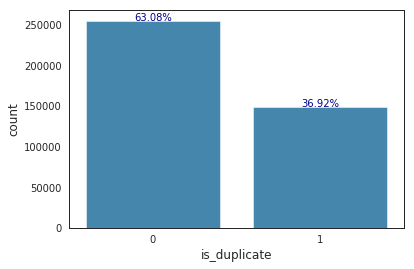

In [8]:
base_color = sns.color_palette()[1]
sns.countplot(data=df, x='is_duplicate', color=base_color);

show_annotation('is_duplicate')

In [9]:
def bg(value, color='blue'):
    return colored(value, color, attrs=['reverse', 'blink'])

In [10]:
totalRows = df.shape[0]
print('~> Total number of question pairs for training:\t', colored(totalRows, 'blue', attrs=['reverse', 'blink']))

~> Total number of question pairs for training:	 404290


In [11]:
numSimilarQuestions    = len(df[df['is_duplicate']==1])
numNotSimilarQuestions = len(df[df['is_duplicate']==0])

print('~> Percentage of Similar Questions (is_duplicate = 1): {:.2f}%'.format(((numSimilarQuestions/totalRows)*100)))
print('~> Percentage of Non-Similar Questions (is_duplicate = 0): {:.2f}%'.format(((numNotSimilarQuestions/totalRows)*100)))

~> Percentage of Similar Questions (is_duplicate = 1): 36.92%
~> Percentage of Non-Similar Questions (is_duplicate = 0): 63.08%


### 3.2.2 Number of unique questions

In [12]:
# Unique questions.
unique_questions = pd.Series(data=list(set(df['qid1']) | set(df['qid2'])))
n_unique_questions = unique_questions.count()
print('~> Number of Unique questions:', bg(n_unique_questions))

# Number of questions that appeared more than one.
qids = pd.Series(list(df['qid1']) + list(df['qid2']))
questions_appear_more_one = (qids.value_counts() > 1)
n_questions_appear_more_one = np.sum(questions_appear_more_one)
print('~> Number of unique questions that appear more than one time:', bg(n_questions_appear_more_one))

# Max number of times for a question that appeared.
max_n_times = max(qids.value_counts())
print('~> Max number of times a single questions is repeated:', bg(max_n_times))

~> Number of Unique questions: 537933
~> Number of unique questions that appear more than one time: 111780
~> Max number of times a single questions is repeated: 157


In [13]:
# x = ['Unique_Question', 'Repeated_Questions']
# y = [unique_questions, questions_appear_more_one]

# plt.figure(figsize=(10, 6))
# plt.title('Plot representing unique and repeated questions')
# sns.barplot(x, y)
# plt.show()

## 3.2.3 Checking for Duplicates

In [14]:
# Checking whether there are any repeated pair of questions
n_pair_duplicates = df.duplicated().sum()
print('~> Number of duplicated pairs:', bg(n_pair_duplicates))

~> Number of duplicated pairs: 0


## 3.2.4 Number of Occurrences of each question

The question that has been questioned the most is: What are the best ways to lose weight?


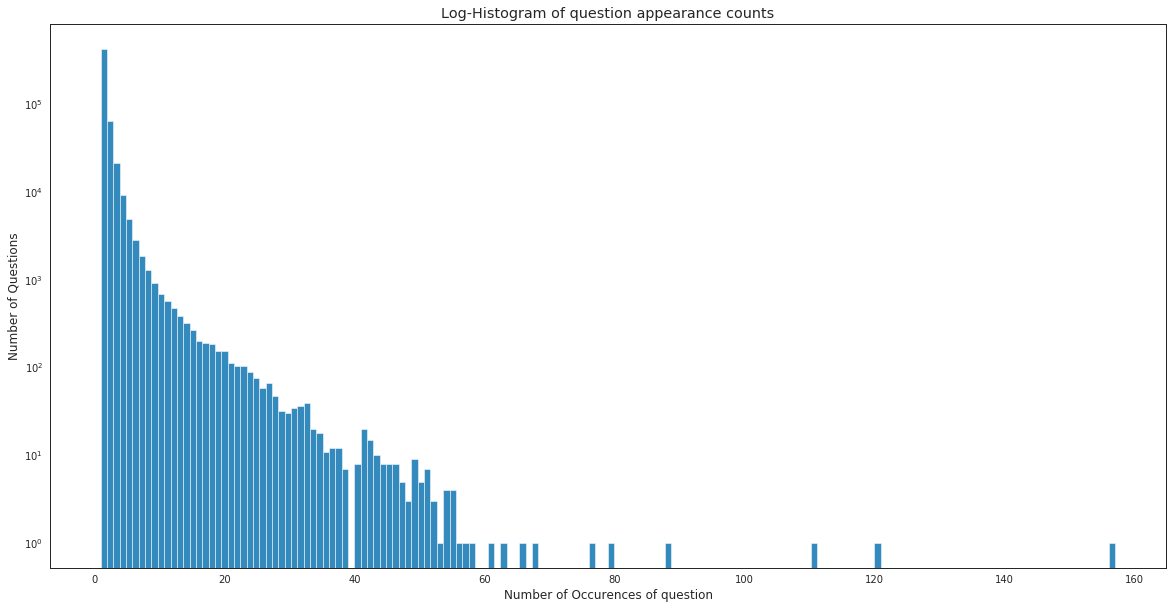

In [15]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160, color=base_color)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of Occurences of question')
plt.ylabel('Number of Questions');
print("The question that has been questioned the most is:", bg(df[df['qid1']==(2559)]['question1'].iloc[0]));

## 3.2.5 Checking for NULL values

In [16]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [17]:
# Checking Null values
df[(df['question1'].isnull()) | (df['question2'].isnull())] 

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [18]:
df = df.fillna('')
df[(df['question1'].isnull()) | (df['question2'].isnull())]

,id,qid1,qid2,question1,question2,is_duplicate
